# Reinforcement Learning
### Last workshop: Multi-armed bandit models and RL basic concepts
### This workshop: Finite Markov Decision Process (MDP)
<ul>
<li>Modeling a GridWorld environment</li>
<li>Planning by Dynamic Programming</li>
<li>Policy Iteration</li>
<li>OpenAI gym</li>  
<li>Monte Carlo</li>
</ul>

# Requirement
## Markov Decison Process
MDPs are classical formulization of sequential decision making
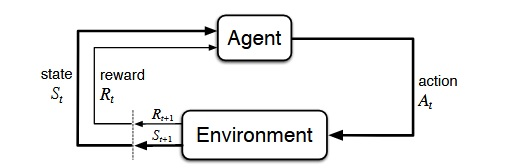
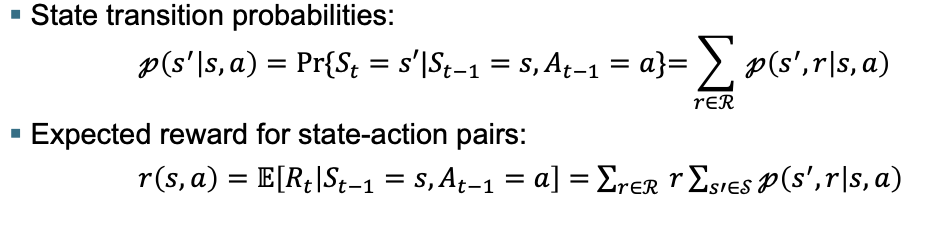

# Policy and Value functions
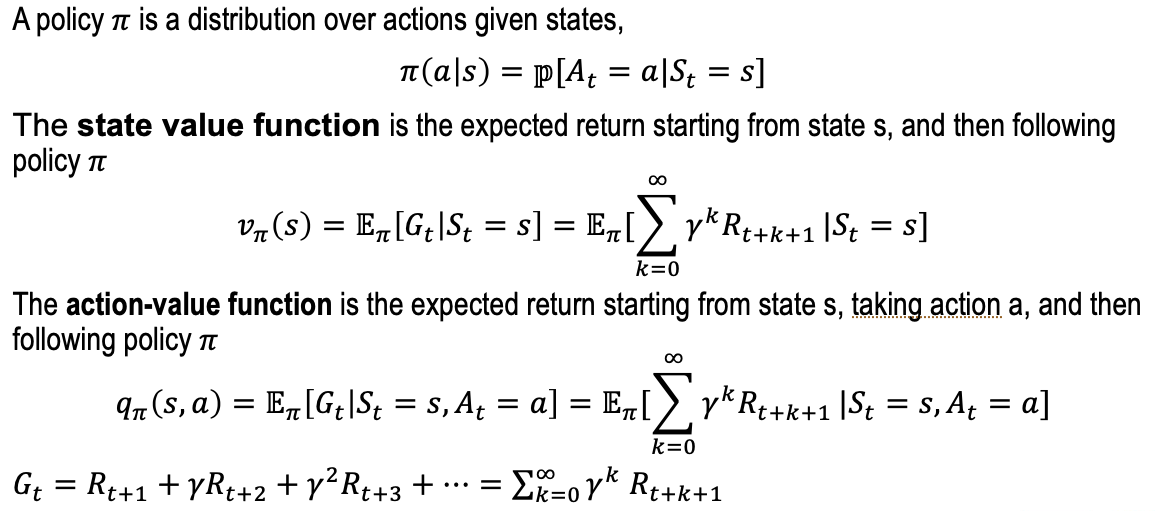

# Bellman expectation equation
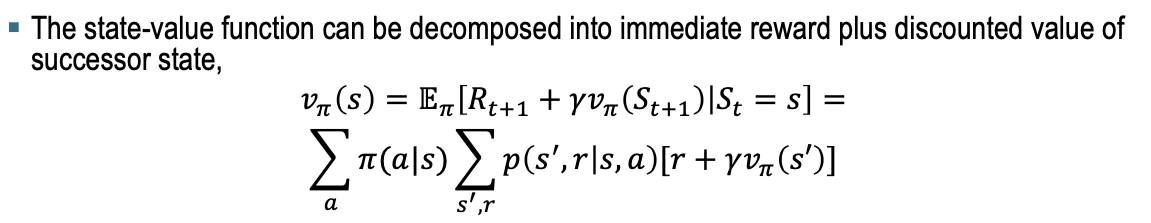

# Solving MDP
## Finding Optimal Policy and Optimal value function
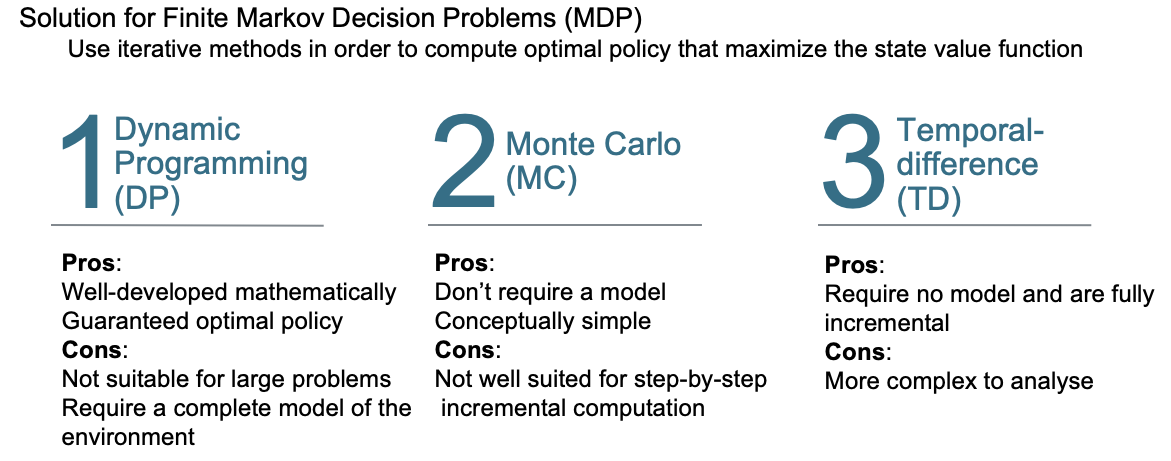

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym

## GridWorld environment

## Dynamic Programming
### We want to solve the GridWorld (Find optimal value function)

## Policy Iteration
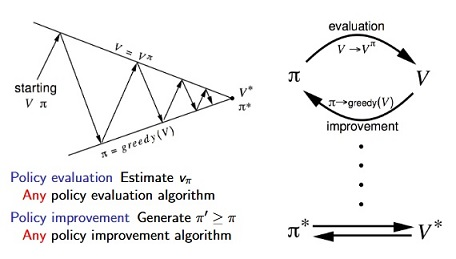

## Applying policy iteration on the Grid World

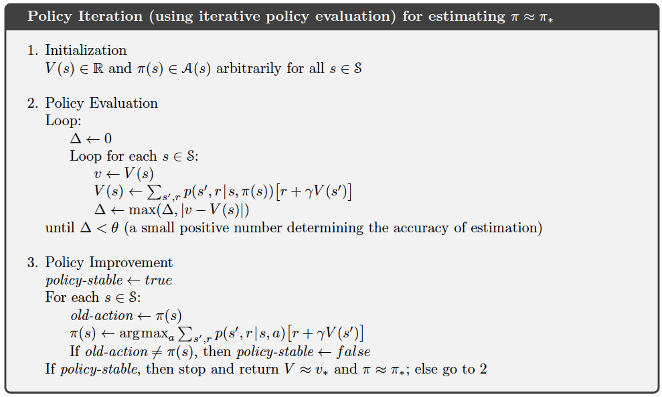

In [41]:
from IPython.core.debugger import set_trace
import numpy as np
import pprint
import sys
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.gridworld import GridworldEnv

## Creating a grid environment using local environments 

In [42]:
pp = pprint.PrettyPrinter(indent=2)
env = GridworldEnv()

### Initializing the policy and value functions

In [43]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V)

In [5]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI environment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    while True:
        # Evaluate the current policy
        V = policy_eval_fn(policy, env, discount_factor)
        
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        
        # For each state...
        for s in range(env.nS):
            # The best action we would take under the current policy
            chosen_a = np.argmax(policy[s])
            
            # Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            action_values = one_step_lookahead(s, V)
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = np.eye(env.nA)[best_a]
        
        # If the policy is stable we've found an optimal policy. Return it
        if policy_stable:
            return policy, V

In [44]:
random_policy = np.ones([env.nS, env.nA]) / env.nA
v = policy_eval(random_policy, env)

In [45]:
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")




Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



# Value Iteration

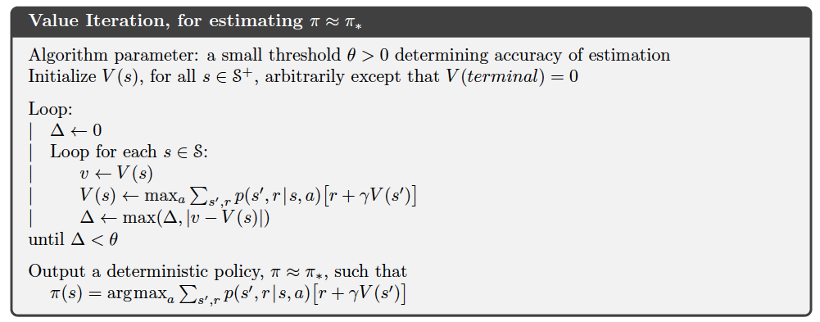

In [46]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    V = np.zeros(env.nS)
    while True:
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(env.nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value        
        # Check if we can stop 
        if delta < theta:
            break
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0
    
    return policy, V

In [47]:
policy, v = value_iteration(env)

print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



### This is Example 4.3. Gambler’s Problem from Sutton's book.

A gambler has the opportunity to make bets on the outcomes of a sequence of coin flips. 
If the coin comes up heads, he wins as many dollars as he has staked on that flip; 
if it is tails, he loses his stake. The game ends when the gambler wins by reaching his goal of $100, 
or loses by running out of money. 

On each flip, the gambler must decide what portion of his capital to stake, in integer numbers of dollars. 
This problem can be formulated as an undiscounted, episodic, finite MDP. 

The state is the gambler’s capital, s ∈ {1, 2, . . . , 99}.
The actions are stakes, a ∈ {0, 1, . . . , min(s, 100 − s)}. 
The reward is zero on all transitions except those on which the gambler reaches his goal, when it is +1.

The state-value function then gives the probability of winning from each state. A policy is a mapping from levels of capital to stakes. The optimal policy maximizes the probability of reaching the goal. Let p_h denote the probability of the coin coming up heads. If p_h is known, then the entire problem is known and it can be solved, for instance, by value iteration.



Implement value iteration for the gambler’s problem and solve it for p_h = 0.25 and p_h = 0.55.

In [10]:
def value_iteration_for_gamblers(p_h, theta=0.0001, discount_factor=1.0):
    """
    Args:
        p_h: Probability of the coin coming up heads
    """
    # The reward is zero on all transitions except those on which the gambler reaches his goal,
    # when it is +1.
    rewards = np.zeros(101)
    rewards[100] = 1
    
    # We introduce two dummy states corresponding to termination with capital of 0 and 100
    V = np.zeros(101)
    
    def one_step_lookahead(s, V, rewards):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            s: The gambler’s capital. Integer.
            V: The vector that contains values at each state. 
            rewards: The reward vector.
                        
        Returns:
            A vector containing the expected value of each action. 
            Its length equals to the number of actions.
        """
        A = np.zeros(101)
        stakes = range(1, min(s, 100-s)+1) # Your minimum bet is 1, maximum bet is min(s, 100-s).
        for a in stakes:
            # rewards[s+a], rewards[s-a] are immediate rewards.
            # V[s+a], V[s-a] are values of the next states.
            # This is the core of the Bellman equation: The expected value of your action is 
            # the sum of immediate rewards and the value of the next state.
            A[a] = p_h * (rewards[s+a] + V[s+a]*discount_factor) + (1-p_h) * (rewards[s-a] + V[s-a]*discount_factor)
        return A
    
    while True:
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(1, 100):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V, rewards)
            # print(s,A,V) # if you want to debug.
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value        
        # Check if we can stop 
        if delta < theta:
            break
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros(100)
    for s in range(1, 100):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V, rewards)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s] = best_action
    
    return policy, V

In [11]:
policy, v = value_iteration_for_gamblers(0.25)

print("Optimized Policy:")
print(policy)
print("")

print("Optimized Value Function:")
print(v)
print("")

Optimized Policy:
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 12. 11. 15. 16. 17.
 18.  6. 20. 21.  3. 23. 24. 25.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.
 11. 12. 38. 11. 10.  9. 42.  7. 44.  5. 46. 47. 48. 49. 50.  1.  2.  3.
  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 11. 10.  9. 17.  7. 19.  5. 21.
 22. 23. 24. 25.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 12. 11.
 10.  9.  8.  7.  6.  5.  4.  3.  2.  1.]

Optimized Value Function:
[0.00000000e+00 7.24792480e-05 2.89916992e-04 6.95257448e-04
 1.16010383e-03 1.76906586e-03 2.78102979e-03 4.03504074e-03
 4.66214120e-03 5.59997559e-03 7.08471239e-03 9.03964043e-03
 1.11241192e-02 1.56793594e-02 1.61464431e-02 1.69517994e-02
 1.86512806e-02 1.98249817e-02 2.24047303e-02 2.73845196e-02
 2.83388495e-02 3.04937363e-02 3.61633897e-02 3.84953022e-02
 4.44964767e-02 6.25000000e-02 6.27174377e-02 6.33700779e-02
 6.45857723e-02 6.59966059e-02 6.78135343e-02 7.08430894e-02
 7.46098323e-02 7.64884604e-02 7.93035477e-02 8.37541372e-02

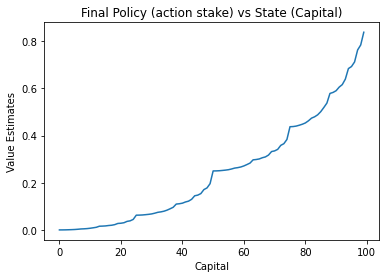

In [12]:
# Plotting Final Policy (action stake) vs State (Capital)

# x axis values
x = range(100)
# corresponding y axis values
y = v[:100]
 
# plotting the points 
plt.plot(x, y)
 
# naming the x axis
plt.xlabel('Capital')
# naming the y axis
plt.ylabel('Value Estimates')
 
# giving a title to the graph
plt.title('Final Policy (action stake) vs State (Capital)')
 
# function to show the plot
plt.show()

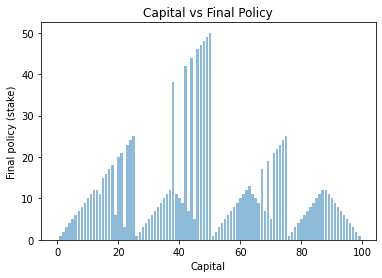

In [13]:
# Plotting Capital vs Final Policy

# x axis values
x = range(100)
# corresponding y axis values
y = policy
 
# plotting the bars
plt.bar(x, y, align='center', alpha=0.5)
 
# naming the x axis
plt.xlabel('Capital')
# naming the y axis
plt.ylabel('Final policy (stake)')
 
# giving a title to the graph
plt.title('Capital vs Final Policy')
 
# function to show the plot
plt.show()

# Open AI gym

Introduction to <a href="https://gym.openai.com/docs/">Open AI gym</a>.

In [50]:
env = gym.make('Taxi-v3')
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



"There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions."

Action Space Discrete(6)
State Space Discrete(500)
<ul>
<li>The filled square represents the taxi, which is yellow without a passenger and green with a passenger</li>
<li>The pipe ("|") represents a wall which the taxi cannot cross.</li>
<li>R, G, Y, B are the possible pickup and destination locations.</li>
<li>The blue letter represents the current passenger pick-up location, and the purple letter is the current destination.</li>  
</ul>

### actions:
<ol>
<li>south</li>
<li>north</li>
<li>east</li>
<li>west</li>
<li>pickup</li>
<li>dropoff</li>
</ol>

In [51]:
# Let's first do some random steps in the game so you see how the game looks like

rew_tot=0
obs= env.reset()
env.render()
for _ in range(100):
    action = env.action_space.sample() #take step using random action from possible actions (actio_space)
    obs, rew, done, info = env.step(action) 
    rew_tot = rew_tot + rew
    env.render()
#Print the reward of these random action
print("Reward: %r" % rew_tot)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B:

In [16]:
# action space has 6 possible actions, the meaning of the actions is nice to know for us humans but the neural network will figure it out
print(env.action_space)
NUM_ACTIONS = env.action_space.n
print("Possible actions: [0..%a]" % (NUM_ACTIONS-1))

Discrete(6)
Possible actions: [0..5]


In [52]:
print(env.observation_space)
print()
env.env.s=42 # some random number, you might recognize it
env.render()
env.env.s = 222 # and some other
env.render()

Discrete(500)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


In [54]:
# Value iteration algorithem
NUM_ACTIONS = env.action_space.n
NUM_STATES = env.observation_space.n
V = np.zeros([NUM_STATES]) # The Value for each state
Pi = np.zeros([NUM_STATES], dtype=int)  # Our policy with we keep updating to get the optimal policy
gamma = 0.9 # discount factor
significant_improvement = 0.01

def best_action_value(s):
    # finds the highest value action (max_a) in state s
    best_a = None
    best_value = float('-inf')

    # loop through all possible actions to find the best current action
    for a in range (0, NUM_ACTIONS):
        env.env.s = s
        s_new, rew, done, info = env.step(a) #take the action
        v = rew + gamma * V[s_new]
        if v > best_value:
            best_value = v
            best_a = a
    return best_a

iteration = 0
while True:
    # biggest_change is referred to by the mathematical symbol delta in equations
    biggest_change = 0
    for s in range (0, NUM_STATES):
        old_v = V[s]
        action = best_action_value(s) #choosing an action with the highest future reward
        env.env.s = s # goto the state
        s_new, rew, done, info = env.step(action) #take the action
        V[s] = rew + gamma * V[s_new] #Update Value for the state using Bellman equation
        Pi[s] = action
        biggest_change = max(biggest_change, np.abs(old_v - V[s]))
    iteration += 1
    if biggest_change < significant_improvement:
        print (iteration,' iterations done')
        break

41  iterations done


In [55]:
# Let's see how the algorithm solves the taxi game
rew_tot=0
obs= env.reset()
env.render()
done=False
while done != True: 
    action = Pi[obs]
    obs, rew, done, info = env.step(action) #take step using selected action
    rew_tot = rew_tot + rew
    env.render()
#Print the reward of these actions
print("Reward: %r" % rew_tot)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Reward: 15


## Playing Blackjack using Monte Carlo

In [56]:
import gym
import numpy as np
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [57]:
env = gym.make('Blackjack-v1')
observation = env.reset()
print(env.action_space, env.observation_space, sep='\n')

Discrete(2)
Tuple(Discrete(32), Discrete(11), Discrete(2))


In [58]:
def make_epsilon_greedy_policy(Q_table, nA, epsilon):
    def generate_policy(observation):
        prob_A = np.ones(nA)*epsilon / nA
        optimal_a = np.argmax(Q_table[observation])
        prob_A[optimal_a] += (1.0 - epsilon)
        return prob_A
    return generate_policy

In [59]:
def generate_one_episode(env, generate_policy):
    trajectory = []
    state = env.reset()
    for i in range(1000):
        Pi_table = generate_policy(state)
        action = np.random.choice(np.arange(len(Pi_table)), p=Pi_table)
        next_state, reward, done, _ = env.step(action)
        trajectory.append((next_state, action, reward))
        if done:
            break
        state = next_state
    return trajectory

In [60]:
def MC_control(env, iteration_times=500000, epsilon=0.1, discount_factor= 1.0):
    Return, Count, Q_table = defaultdict(float), defaultdict(float), defaultdict(lambda: np.zeros(env.action_space.n))
    policy = make_epsilon_greedy_policy(Q_table, env.action_space.n, epsilon)
    for i in range(iteration_times):
        trajectory = generate_one_episode(env, policy)
        s_a_pairs = set([(x[0], x[1]) for x in trajectory])
        for state, action in s_a_pairs:
            s_a = (state, action)
            first_visit_id = next(i for i, x in enumerate(trajectory) if x[0] == state and x[1] == action)
            G = sum([x[2]*(discount_factor**i) for i, x in enumerate(trajectory[first_visit_id:])])
            Return[s_a] += G
            Count[s_a] += 1.
            Q_table[state][action] = Return[s_a] / Count[s_a]
    return policy, Q_table

In [61]:
def plot_value_function(Q_table):
    x = np.arange(12, 21)
    y = np.arange(1, 10)
    X, Y = np.meshgrid(x, y)
    Z_noace = np.apply_along_axis(lambda x: Q_table[(x[0], x[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda x: Q_table[(x[0], x[1], True)], 2, np.dstack([X, Y]))
    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 12))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('\nPlayer Sum', fontsize=25)
        ax.set_ylabel('\nDealer Showing', fontsize=25)
        ax.set_zlabel('\nValue', fontsize=25)
        ax.set_title('\n\n' + title, fontsize=25)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        # plt.savefig('../RL/%s.png'%title)
        plt.show()
    plot_surface(X, Y, Z_noace, '{}(not use Ace)'.format('optimal value function'))
    plot_surface(X, Y, Z_ace, '{}(use Ace)'.format('optimal Value function'))

In [27]:
optimal_policy, Q_table = MC_control(env)
V = defaultdict(float)
for state, action_value in Q_table.items():
    V[state] = np.max(action_value)

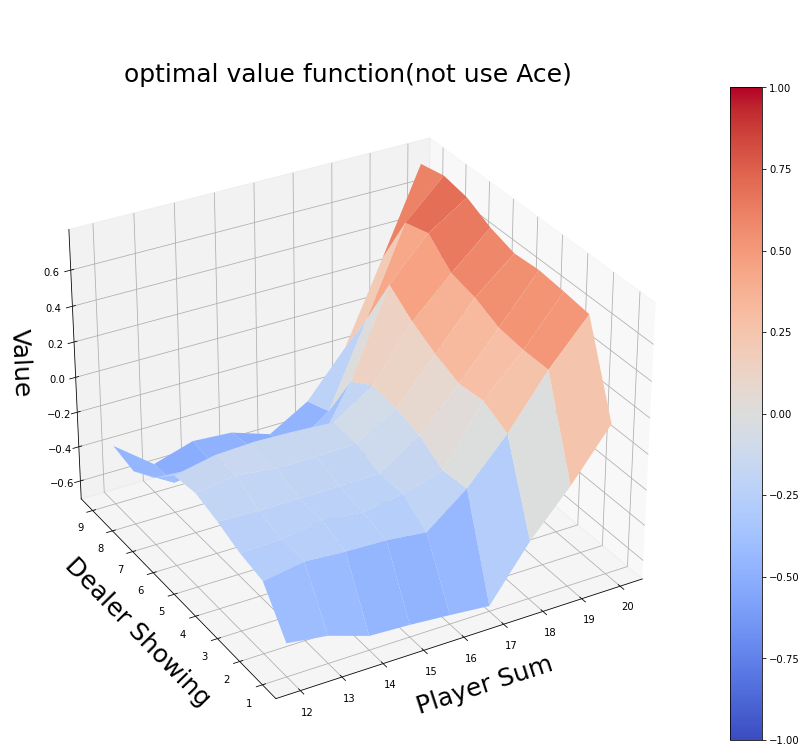

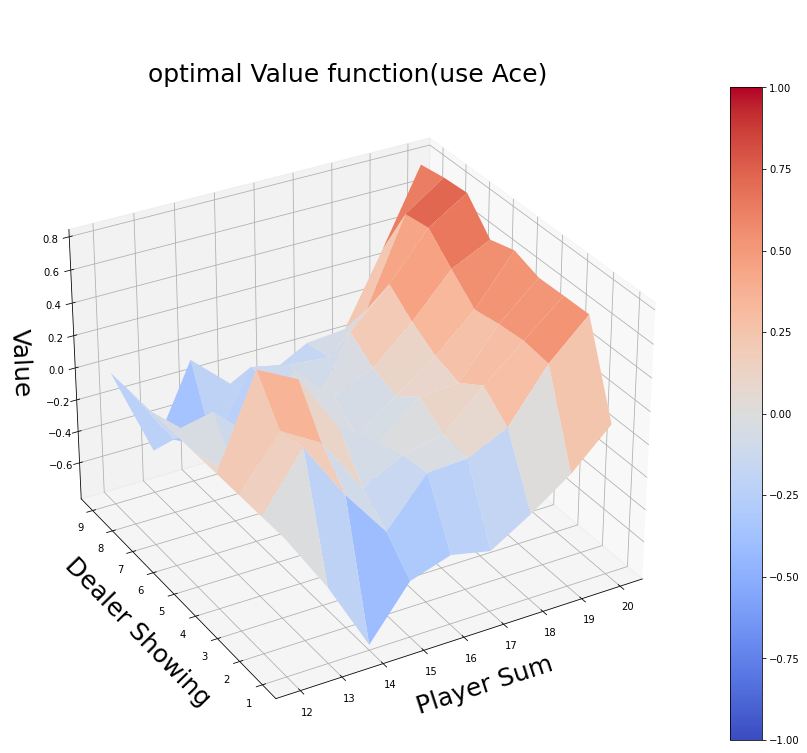

In [28]:
plot_value_function(V)